In [2]:
import bisect 
import math
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import statistics

# Constants

In [98]:
SIM_DURATION = 100
NUMBER_OF_GRAPHS = 100
MAX_SEARCH_TIME = 5
IS_ACTIVE_MODEL = True
NUMBER_OF_NODES = 30
LAMBDA = 2
ALPHA = 3
BETA = 1
LAMBDA_POISSON = 0.2
N = 2
P = 0.1
DISTRIBUTION = 'exponential'

In [99]:
def reset_constants():
  global MAX_SEARCH_TIME, LAMBDA, ALPHA, BETA, LAMBDA_POISSON, N, P
  MAX_SEARCH_TIME = 5
  LAMBDA = 2
  ALPHA = 3
  BETA = 1
  LAMBDA_POISSON = 0.2
  N = 2
  P = 0.1

# Generate random numbers

In [88]:
def random_list_exponential_distribution(n, my_lambda = LAMBDA):
  random_numbers = np.random.exponential(scale=(1/my_lambda), size=n)
  random_numbers = random_numbers * SIM_DURATION
  return random_numbers.astype(int).tolist()

def random_list_pareto_distribution(n, alpha=ALPHA, beta=BETA):
  random_numbers = (np.random.pareto(alpha, n)) * beta
  random_numbers = random_numbers * SIM_DURATION
  return random_numbers.astype(int).tolist()

def random_list_poisson_distribution(n, my_lambda=LAMBDA_POISSON):
  random_numbers = np.random.poisson(my_lambda, n)
  random_numbers = random_numbers * SIM_DURATION
  return random_numbers.astype(int).tolist()

def random_list_binomial_distribution(n, n_binomial=N, p=P):
  random_numbers = np.random.binomial(n_binomial, p, n)
  random_numbers = random_numbers * SIM_DURATION
  return random_numbers.astype(int).tolist()

In [5]:
# we use ER graphs
def create_graphs(n, p, graphsNo):
  ER_graphs = [None for i in range(graphsNo)]
  for i in range(graphsNo):
    G = nx.erdos_renyi_graph(n, p)
    ER_graphs[i] = G
  return ER_graphs

In [89]:
### returns element-lifetime pairs in discending order
def set_lifetimes(nodes, edges):
  nodes_lifetimes, edges_lifetimes = [], []
  if DISTRIBUTION == 'exponential':
    nodes_lifetimes = random_list_exponential_distribution(len(nodes))
    edges_lifetimes = random_list_exponential_distribution(len(edges))
  elif DISTRIBUTION == 'pareto':
    nodes_lifetimes = random_list_pareto_distribution(len(nodes))
    edges_lifetimes = random_list_pareto_distribution(len(edges))
  elif DISTRIBUTION == 'poisson':
    nodes_lifetimes = random_list_poisson_distribution(len(nodes))
    edges_lifetimes = random_list_poisson_distribution(len(edges))
  elif DISTRIBUTION == 'binomial':
    nodes_lifetimes = random_list_binomial_distribution(len(nodes))
    edges_lifetimes = random_list_binomial_distribution(len(edges))
  return sorted([i for i in zip(nodes_lifetimes, nodes)], reverse=True), sorted([i for i in zip(edges_lifetimes, edges)], reverse=True), np.mean(nodes_lifetimes)

# Main code

In [33]:
def node_is_isolated(G, node):
  if not G.has_node(node):
    return 0
  return G.degree[node] == 0


def search_procedure(G, t, node, edges_to_add):
  # get a random number between 1 and max_search_time that will be the required time to find a new node to connect to
  search_time = math.ceil(random.random() * MAX_SEARCH_TIME)
  # search_time = 0
  # get a random node to connect to
  nodes = list(G.nodes)
  selected_node = random.choices(nodes)[0]
  # add the new connection to the sorted list
  new_edge_to_add = (t+search_time, (node, selected_node))
  edges_to_add.reverse()
  bisect.insort(edges_to_add, new_edge_to_add)
  edges_to_add.reverse()
  return edges_to_add


def add_isolation_time(Ts, t, node):
  if Ts[node] == SIM_DURATION:
  # if Ts[node] == -1:
    Ts[node] = t


def remove_nodes(G , nodes, t, edges_to_add, Ts):
  for node in nodes:
    neighbors = list(G.neighbors(node))
    G.remove_node(node)
    for neighbor in neighbors:
      if IS_ACTIVE_MODEL:
        search_procedure(G, t, neighbor, edges_to_add)
      if node_is_isolated(G, neighbor):
        add_isolation_time(Ts, t, neighbor)


def remove_edges(G , edges, t, edges_to_add, Ts):
  for edge in edges:
    node1, node2 = edge
    if (not G.has_node(node1)) or (not G.has_node(node2)) or (not G.has_edge(node1, node2)):
      continue
    G.remove_edge(node1, node2)
    if IS_ACTIVE_MODEL:
      search_procedure(G, t, node1, edges_to_add)
      search_procedure(G, t, node2, edges_to_add)
    if node_is_isolated(G, node1):
      add_isolation_time(Ts, t, node1)
    if node_is_isolated(G, node2):
      add_isolation_time(Ts, t, node2)


def check_lifetimes_and_remove(G, t, nodes_lifetimes, edges_lifetimes, Ts, edges_to_add):
  nodes_to_remove = []
  edges_to_remove = []
  while nodes_lifetimes and nodes_lifetimes[-1][0] <= t:
    nodes_to_remove.append(nodes_lifetimes.pop()[1])
  while edges_lifetimes and edges_lifetimes[-1][0] <= t:
    edges_to_remove.append(edges_lifetimes.pop()[1])

  remove_nodes(G, nodes_to_remove, t, edges_to_add, Ts);
  remove_edges(G, edges_to_remove, t, edges_to_add, Ts);

def add_new_edges(edges_to_add, edges_lifetimes, t, G):
  new_edges = []
  while edges_to_add and edges_to_add[-1][0] <= t:
    new_edge = edges_to_add.pop()[1]
    G.add_edge(new_edge[0], new_edge[1])
    new_edges.append(new_edge)
  _, new_edges_lifetimes, _ = set_lifetimes([], new_edges)
  edges_lifetimes = sorted(edges_lifetimes + new_edges_lifetimes, reverse=True)

In [8]:
def simulation(G, nodes_lifetimes, edges_lifetimes):
  # Ts = [-1 for x in range(len(nodes_lifetimes))]
  Ts = [0 if node_is_isolated(G, x) else SIM_DURATION for x in range(len(nodes_lifetimes))]
  edges_to_add = []
  for t in range(1, SIM_DURATION+1):
    check_lifetimes_and_remove(G, t, nodes_lifetimes, edges_lifetimes, Ts, edges_to_add)
    if IS_ACTIVE_MODEL:
      add_new_edges(edges_to_add, edges_lifetimes, t, G)

  # for index in range(len(Ts)-1, -1, -1):
  #   if Ts[index] == -1:
  #     del Ts[index]
  # if not Ts:
  #   return SIM_DURATION
  return Ts

In [34]:
def run_simulation(p, T_avgs_avg, average_degrees_avg, phis, average_lifetimes_avg):
  graphs = create_graphs(NUMBER_OF_NODES, p, NUMBER_OF_GRAPHS)
  average_degrees = []
  T_avgs = []
  lifetimes_avg = []
  number_of_isolated_graphs = 0
  for g in graphs:
    average_degrees.append(2*g.number_of_edges() / float(g.number_of_nodes()))
    nodes_lifetimes, edges_lifetimes, avg_lifetime = set_lifetimes(g.nodes, g.edges)
    Ts = simulation(g, nodes_lifetimes, edges_lifetimes)
    lifetimes_avg.append(avg_lifetime)
    T_avgs.append(statistics.mean(Ts))
    number_of_isolated_graphs += 1 if min(Ts) != SIM_DURATION else 0
  T_avgs_avg.append(statistics.mean(T_avgs))
  average_degrees_avg.append(statistics.mean(average_degrees))
  phis.append(number_of_isolated_graphs/NUMBER_OF_GRAPHS)
  average_lifetimes_avg.append(np.mean(lifetimes_avg))

# Results for part A

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


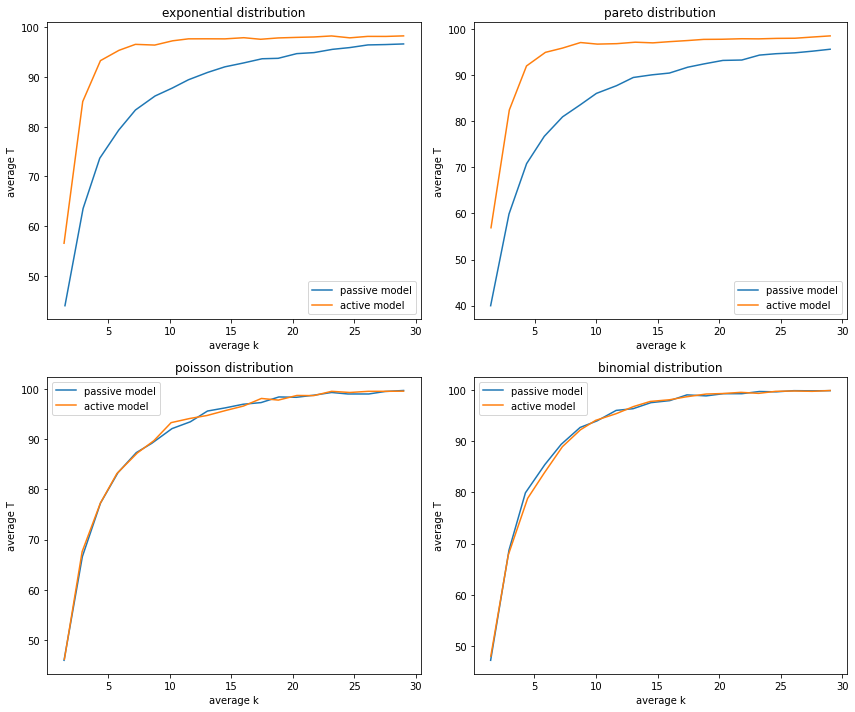

In [100]:
ps = [i/20 for i in range(1, 21)]
plt.figure(figsize=(12,10))

# exponential
plt.subplot(2,2,1)
reset_constants()
IS_ACTIVE_MODEL = False
DISTRIBUTION = 'exponential'
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for p in ps:
  run_simulation(p, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(degrees_avgs, T_avgs, label='passive model')

reset_constants()
IS_ACTIVE_MODEL = True
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for p in ps:
  run_simulation(p, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(degrees_avgs, T_avgs, label='active model')
plt.xlabel('average k')
plt.ylabel('average T')
plt.title('exponential distribution')
plt.legend()

# pareto
plt.subplot(2,2,2)
reset_constants()
IS_ACTIVE_MODEL = False
DISTRIBUTION = 'pareto'
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for p in ps:
  run_simulation(p, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(degrees_avgs, T_avgs, label='passive model')

reset_constants()
IS_ACTIVE_MODEL = True
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for p in ps:
  run_simulation(p, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(degrees_avgs, T_avgs, label='active model')
plt.xlabel('average k')
plt.ylabel('average T')
plt.title('pareto distribution')
plt.legend()

# poisson
plt.subplot(2,2,3)
reset_constants()
IS_ACTIVE_MODEL = False
DISTRIBUTION = 'poisson'
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for p in ps:
  run_simulation(p, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(degrees_avgs, T_avgs, label='passive model')

reset_constants()
IS_ACTIVE_MODEL = True
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for p in ps:
  run_simulation(p, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(degrees_avgs, T_avgs, label='active model')
plt.xlabel('average k')
plt.ylabel('average T')
plt.title('poisson distribution')
plt.legend()

# binomial
plt.subplot(2,2,4)
reset_constants()
IS_ACTIVE_MODEL = False
DISTRIBUTION = 'binomial'
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for p in ps:
  run_simulation(p, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(degrees_avgs, T_avgs, label='passive model')

reset_constants()
IS_ACTIVE_MODEL = True
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for p in ps:
  run_simulation(p, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(degrees_avgs, T_avgs, label='active model')
plt.xlabel('average k')
plt.ylabel('average T')
plt.title('binomial distribution')
plt.legend()
plt.tight_layout()

# Results for part B

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


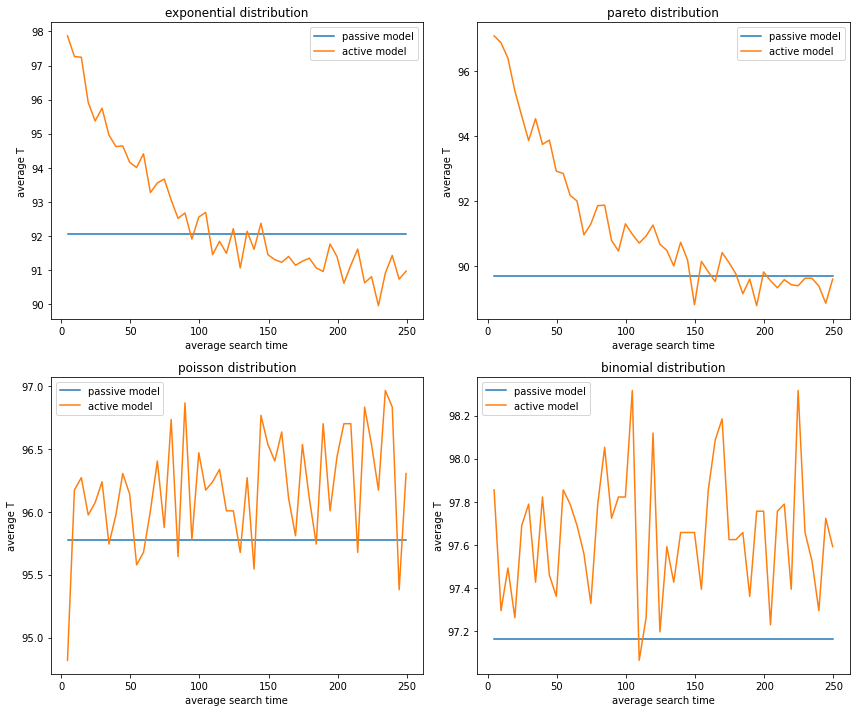

In [102]:
max_search_times = [i*10 for i in range(1, 51)]
mean_search_times = [(i-1)/2 for i in max_search_times]
plt.figure(figsize=(12,10))

# exponential
plt.subplot(2,2,1)
reset_constants()
IS_ACTIVE_MODEL = False
DISTRIBUTION = 'exponential'
T_avgs, phis1, degrees_avgs, lifetimes_avgs = [], [], [], []
run_simulation(0.5, T_avgs, degrees_avgs, phis1, lifetimes_avgs)
T_avgs = [T_avgs[0] for x in range(len(mean_search_times))]
phis1 = [phis1[0] for x in range(len(mean_search_times))]
plt.plot(mean_search_times, T_avgs, label='passive model')

reset_constants()
IS_ACTIVE_MODEL = True
T_avgs, phis2, degrees_avgs, lifetimes_avgs = [], [], [], []
for mst in max_search_times:
  MAX_SEARCH_TIME = mst
  run_simulation(0.5, T_avgs, degrees_avgs, phis2, lifetimes_avgs)
plt.plot(mean_search_times, T_avgs, label='active model')
plt.xlabel('average search time')
plt.ylabel('average T')
plt.title('exponential distribution')
plt.legend()

# pareto
plt.subplot(2,2,2)
reset_constants()
IS_ACTIVE_MODEL = False
DISTRIBUTION = 'pareto'
T_avgs, phis3, degrees_avgs, lifetimes_avgs = [], [], [], []
run_simulation(0.5, T_avgs, degrees_avgs, phis3, lifetimes_avgs)
T_avgs = [T_avgs[0] for x in range(len(mean_search_times))]
phis3 = [phis3[0] for x in range(len(mean_search_times))]
plt.plot(mean_search_times, T_avgs, label='passive model')

reset_constants()
IS_ACTIVE_MODEL = True
T_avgs, phis4, degrees_avgs, lifetimes_avgs = [], [], [], []
for mst in max_search_times:
  MAX_SEARCH_TIME = mst
  run_simulation(0.5, T_avgs, degrees_avgs, phis4, lifetimes_avgs)
plt.plot(mean_search_times, T_avgs, label='active model')
plt.xlabel('average search time')
plt.ylabel('average T')
plt.title('pareto distribution')
plt.legend()

# poisson
plt.subplot(2,2,3)
reset_constants()
IS_ACTIVE_MODEL = False
DISTRIBUTION = 'poisson'
T_avgs, phis5, degrees_avgs, lifetimes_avgs = [], [], [], []
run_simulation(0.5, T_avgs, degrees_avgs, phis5, lifetimes_avgs)
T_avgs = [T_avgs[0] for x in range(len(mean_search_times))]
phis5 = [phis5[0] for x in range(len(mean_search_times))]
plt.plot(mean_search_times, T_avgs, label='passive model')

reset_constants()
IS_ACTIVE_MODEL = True
T_avgs, phis6, degrees_avgs, lifetimes_avgs = [], [], [], []
for mst in max_search_times:
  MAX_SEARCH_TIME = mst
  run_simulation(0.5, T_avgs, degrees_avgs, phis6, lifetimes_avgs)
plt.plot(mean_search_times, T_avgs, label='active model')
plt.xlabel('average search time')
plt.ylabel('average T')
plt.title('poisson distribution')
plt.legend()

# binomial
plt.subplot(2,2,4)
reset_constants()
IS_ACTIVE_MODEL = False
DISTRIBUTION = 'binomial'
T_avgs, phis7, degrees_avgs, lifetimes_avgs = [], [], [], []
run_simulation(0.5, T_avgs, degrees_avgs, phis7, lifetimes_avgs)
T_avgs = [T_avgs[0] for x in range(len(mean_search_times))]
phis7 = [phis7[0] for x in range(len(mean_search_times))]
plt.plot(mean_search_times, T_avgs, label='passive model')

reset_constants()
IS_ACTIVE_MODEL = True
T_avgs, phis8, degrees_avgs, lifetimes_avgs = [], [], [], []
for mst in max_search_times:
  MAX_SEARCH_TIME = mst
  run_simulation(0.5, T_avgs, degrees_avgs, phis8, lifetimes_avgs)
plt.plot(mean_search_times, T_avgs, label='active model')
plt.xlabel('average search time')
plt.ylabel('average T')
plt.title('binomial distribution')
plt.legend()
plt.tight_layout()

# Results for part C

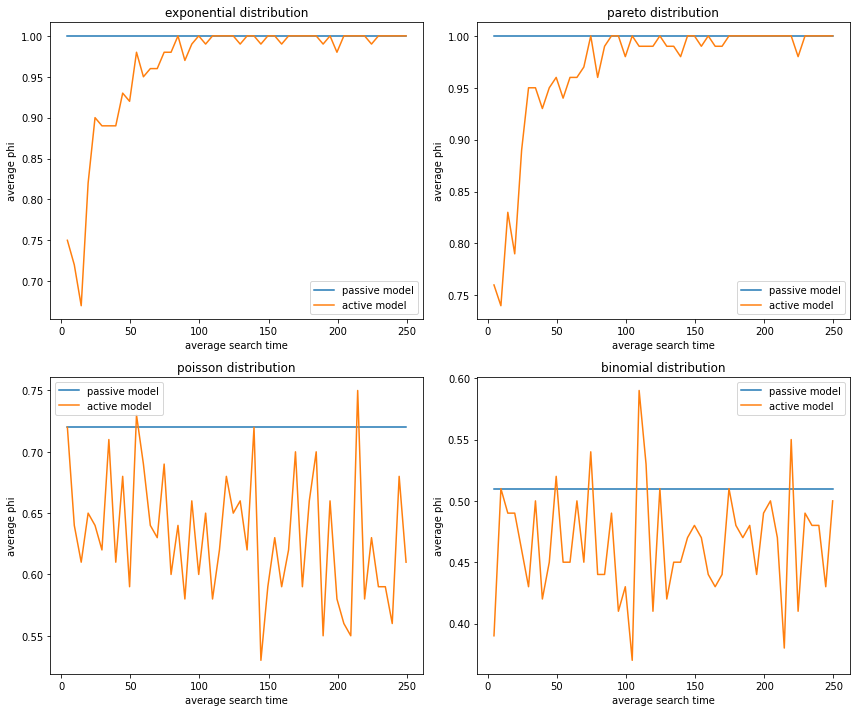

In [104]:
plt.figure(figsize=(12,10))

# exponential
plt.subplot(2,2,1)
plt.plot(mean_search_times, phis1, label='passive model')
plt.plot(mean_search_times, phis2, label='active model')
plt.xlabel('average search time')
plt.ylabel('average phi')
plt.title('exponential distribution')
plt.legend()

# pareto
plt.subplot(2,2,2)
plt.plot(mean_search_times, phis3, label='passive model')
plt.plot(mean_search_times, phis4, label='active model')
plt.xlabel('average search time')
plt.ylabel('average phi')
plt.title('pareto distribution')
plt.legend()

# poisson
plt.subplot(2,2,3)
plt.plot(mean_search_times, phis5, label='passive model')
plt.plot(mean_search_times, phis6, label='active model')
plt.xlabel('average search time')
plt.ylabel('average phi')
plt.title('poisson distribution')
plt.legend()

# binomial
plt.subplot(2,2,4)
plt.plot(mean_search_times, phis7, label='passive model')
plt.plot(mean_search_times, phis8, label='active model')
plt.xlabel('average search time')
plt.ylabel('average phi')
plt.title('binomial distribution')
plt.legend()
plt.tight_layout()

# Results for part D

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


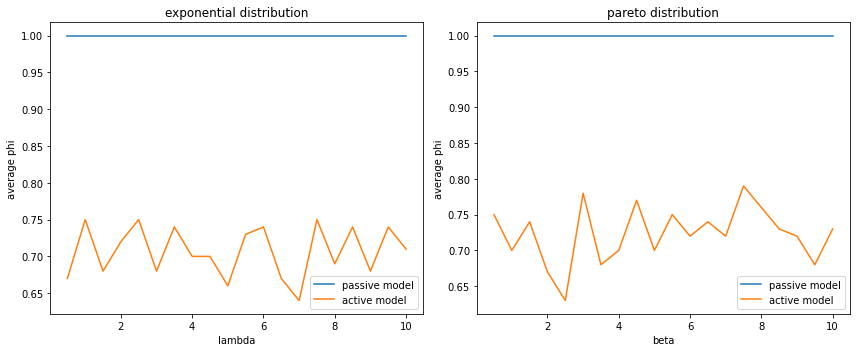

In [105]:
plt.figure(figsize=(12,5))
reset_constants()
lambdas = [x/2 for x in range(1, 21)]

# exponential
plt.subplot(1,2,1)
IS_ACTIVE_MODEL = False
DISTRIBUTION = 'exponential'
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for l in lambdas:
  LAMBDA = l
  run_simulation(0.5, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(lambdas, phis, label='passive model')

IS_ACTIVE_MODEL = True
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for b in lambdas:
  BETA = b
  run_simulation(0.5, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(lambdas, phis, label='active model')
plt.xlabel('lambda')
plt.ylabel('average phi')
plt.title('exponential distribution')
plt.legend()

# pareto
plt.subplot(1,2,2)
IS_ACTIVE_MODEL = False
DISTRIBUTION = 'pareto'
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for l in lambdas:
  LAMBDA = l
  run_simulation(0.5, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(lambdas, phis, label='passive model')

IS_ACTIVE_MODEL = True
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for l in lambdas:
  LAMBDA = l
  run_simulation(0.5, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(lambdas, phis, label='active model')
plt.xlabel('beta')
plt.ylabel('average phi')
plt.title('pareto distribution')
plt.legend()
plt.tight_layout()

# Results for part E

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


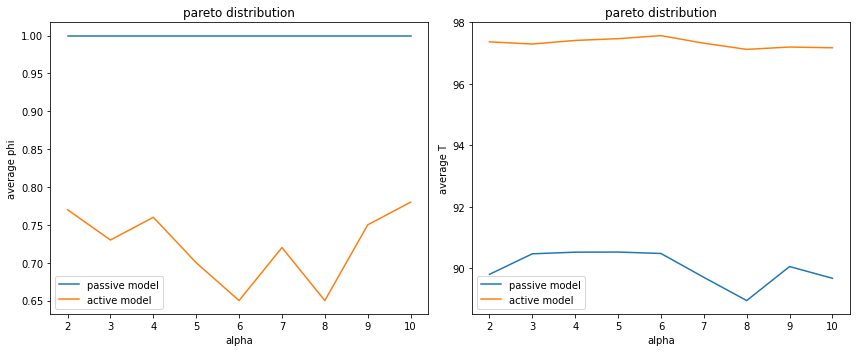

In [106]:
plt.figure(figsize=(12,5))
reset_constants()
alphas = [x for x in range(2, 11)]

# phi
plt.subplot(1,2,1)
IS_ACTIVE_MODEL = False
DISTRIBUTION = 'pareto'
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for a in alphas:
  ALPHA = a
  run_simulation(0.5, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(alphas, phis, label='passive model')

IS_ACTIVE_MODEL = True
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for a in alphas:
  ALPHA = a
  run_simulation(0.5, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(alphas, phis, label='active model')
plt.xlabel('alpha')
plt.ylabel('average phi')
plt.title('pareto distribution')
plt.legend()

# E[T]
plt.subplot(1,2,2)
IS_ACTIVE_MODEL = False
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for a in alphas:
  ALPHA = a
  run_simulation(0.5, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(alphas, T_avgs, label='passive model')

IS_ACTIVE_MODEL = True
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for a in alphas:
  ALPHA = a
  run_simulation(0.5, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(alphas, T_avgs, label='active model')
plt.xlabel('alpha')
plt.ylabel('average T')
plt.title('pareto distribution')
plt.legend()
plt.tight_layout()

# Evaluating number 7 formula (phi <= E[Li]/E[T])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


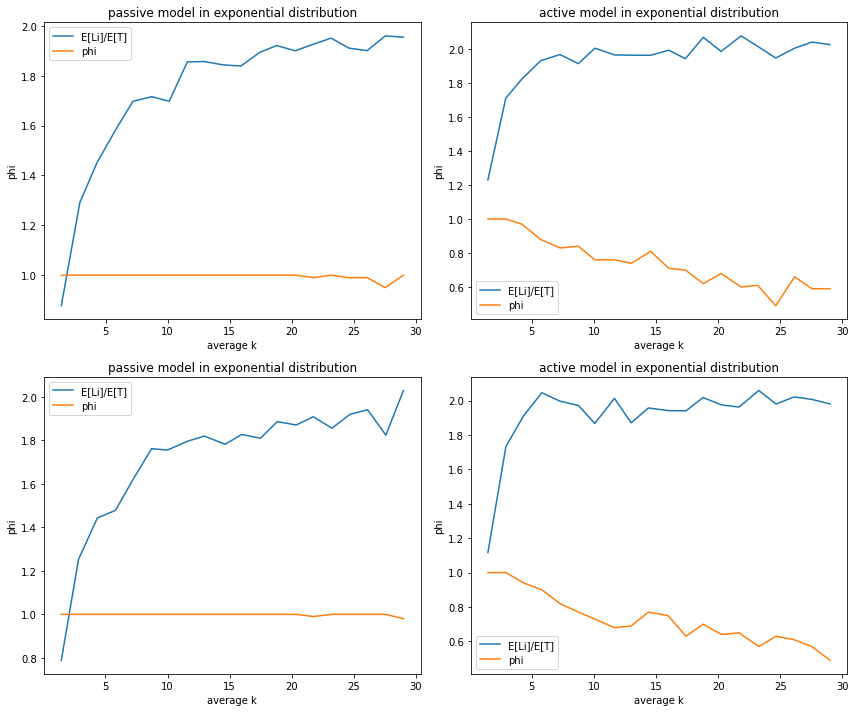

In [109]:
ps = [i/20 for i in range(1, 21)]
plt.figure(figsize=(12,10))

# exponential
plt.subplot(2,2,1)
reset_constants()
IS_ACTIVE_MODEL = False
DISTRIBUTION = 'exponential'
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for p in ps:
  run_simulation(p, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(degrees_avgs, [y / x for x, y in zip(lifetimes_avgs, T_avgs)], label='E[Li]/E[T]')
plt.plot(degrees_avgs, phis, label='phi')
plt.xlabel('average k')
plt.ylabel('phi')
plt.title('passive model in exponential distribution')
plt.legend()

plt.subplot(2,2,2)
reset_constants()
IS_ACTIVE_MODEL = True
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for p in ps:
  run_simulation(p, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(degrees_avgs, [y / x for x, y in zip(lifetimes_avgs, T_avgs)], label='E[Li]/E[T]')
plt.plot(degrees_avgs, phis, label='phi')
plt.xlabel('average k')
plt.ylabel('phi')
plt.title('active model in exponential distribution')
plt.legend()

# pareto
plt.subplot(2,2,3)
reset_constants()
IS_ACTIVE_MODEL = False
DISTRIBUTION = 'pareto'
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for p in ps:
  run_simulation(p, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(degrees_avgs, [y / x for x, y in zip(lifetimes_avgs, T_avgs)], label='E[Li]/E[T]')
plt.plot(degrees_avgs, phis, label='phi')
plt.xlabel('average k')
plt.ylabel('phi')
plt.title('passive model in exponential distribution')
plt.legend()

plt.subplot(2,2,4)
reset_constants()
IS_ACTIVE_MODEL = True
T_avgs, phis, degrees_avgs, lifetimes_avgs = [], [], [], []
for p in ps:
  run_simulation(p, T_avgs, degrees_avgs, phis, lifetimes_avgs)
plt.plot(degrees_avgs, [y / x for x, y in zip(lifetimes_avgs, T_avgs)], label='E[Li]/E[T]')
plt.plot(degrees_avgs, phis, label='phi')
plt.xlabel('average k')
plt.ylabel('phi')
plt.title('active model in exponential distribution')
plt.legend()
plt.tight_layout()